# Lane Detection Project

In this project you need to construct computer vision solution for a lane detection. We are going to implement [LaneNet](https://arxiv.org/pdf/1802.05591.pdf) paper. Our solution is going to have the following parts:

1. Lane semantic segmentation and metric learning
2. Instance segmentation over embedings
3. Homography prediction
4. Lane fitting

We are going to use [TuSimple](https://github.com/TuSimple/tusimple-benchmark/issues/3) dataset for a lane detection.

Let's discuss every step in details.

## Semantic and Instance Segmentation

In this part you should implement and train neural network with the 2 heads. The model should take as an input image and returns to masks. One head should predict *semantic segmentation* and another head should predict *embedding for each pixel*. Pixels that are part of one lane should have similar embeddings, on the other hand pixels from different lanes should have high distance between embeddings. In order to do that, we should implement *discriminative loss*.

After training the discribed network, we can threshold pixels of the interest and cluster them according to the embedding with the *DBSCAN*.

After solving the problem you should obtain the following result.

## Homograpy Prediction

In order to solve the problem, we would like to understand an exact lane geometry. We are going to describe the lane with the 2-nd order polynom $ax^2 + bx + c$.

In the image plane lines are not parallel and we may need higher order polynoms to discribe the lane geometry. In order to avoid that we could project image in the bird's eye view with the homography. But drivable surface has different properties over frames, so we would like to condition the homography on the image.

In order to do that, we going to train separate network to predict the best homography for each image.

## Lane Fitting

After predicting homography and lane's clustering we will fit 2-nd order polynom for each lane to obtain the final result. Lane fitting can be formulated as a least-squares problem, where we have points $\{x_i, y_i\}_{i=1}^n$ and we would like to estimation coefficients $a, b, c$ s.t.

$$
\sum_{i = 1}^n ||y_i - a x_i^2 - bx_i - c||^2 \rightarrow \min_{a, b,c}
$$



## Important Notes
0. During the project we provide the relevant papers. Reading the papers can be very helpful (and sometimes necessary) to implement the code.
1. During the project we provide you with the code templates that you should fill.
2. Homography Prediction and Instance Segmentation can be done in parallel.
3. You are free to use any other environment instead of Google Colab.
4. You can deviate from the original papers if it helps you to solve the problem, but you should explain your solution and motivation in the text block.

## Semantic and Segmentation Code

You can use the following commands to download the dataset and unpack it. But we suggest to upload the data to the Google Drive, with Google Drive you will be able to access the data much faster.

In [ ]:
!mkdir /data/clips

In [ ]:
!mkdir -p /data/testing
!wget https://s3.us-east-2.amazonaws.com/benchmark-frontend/datasets/1/test_set.zip
!unzip test_set.zip -d /data/testing
!mv /data/testing/clips/* /data/clips/
!rm test_set.zip

rm: cannot remove 'test_set.zip': No such file or directory


In [ ]:
!mkdir -p /data/training
!wget https://s3.us-east-2.amazonaws.com/benchmark-frontend/datasets/1/train_set.zip
!unzip train_set.zip -d /data/training
!mv /data/training/clips/* /data/clips/
!mv /data/training/clips/0531/* /data/clips/0531/
!mv /data/training/clips/0601/* /data/clips/0601/
!rm train_set.zip

rm: cannot remove 'train_set.zip': No such file or directory


In the following cell you should implement pytorch Dataset to generate training examples for instance and semantic segmentation. You are able to modify the signatures if you want.

To implement the LaneDataset you should become familiar with the labeling format.

The dataset is relatively small, so it is important to implement different augmentation strategies. We suggest to use random flips and color augmentations (brightness, saturation). You can also use augmentations of your choice. Augmentations are not required to obtain a full grade but without them your model could overfit dramatically.

NOTE: It can be useful to generate binary segmentation and instance segmentation ground truth once and then use it as-is in every experiment.

In [ ]:
import torch

In [ ]:
import argparse
import glob
import json
import os
import os.path as ops
import shutil

import cv2
import numpy as np


def init_args():
    """
    :return:
    """
    parser = argparse.ArgumentParser()
    parser.add_argument('--src_dir', type=str, help='The origin path of unzipped tusimple dataset')

    return parser.parse_args()


def process_json_file(json_file_path, src_dir, ori_dst_dir, binary_dst_dir, instance_dst_dir):

    assert ops.exists(json_file_path), '{:s} not exist'.format(json_file_path)

    image_nums = len(os.listdir(ori_dst_dir))

    with open(json_file_path, 'r') as file:
        for line_index, line in enumerate(file):
            info_dict = json.loads(line)

            image_dir = ops.split(info_dict['raw_file'])[0]
            image_dir_split = image_dir.split('/')[1:]
            image_dir_split.append(ops.split(info_dict['raw_file'])[1])
            image_name = '_'.join(image_dir_split)
            image_path = ops.join(src_dir, info_dict['raw_file'])
            assert ops.exists(image_path), '{:s} not exist'.format(image_path)

            h_samples = info_dict['h_samples']
            lanes = info_dict['lanes']

            image_name_new = '{:s}.png'.format('{:d}'.format(line_index + image_nums).zfill(4))

            src_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            dst_binary_image = np.zeros([src_image.shape[0], src_image.shape[1]], np.uint8)
            dst_instance_image = np.zeros([src_image.shape[0], src_image.shape[1]], np.uint8)

            for lane_index, lane in enumerate(lanes):
                assert len(h_samples) == len(lane)
                lane_x = []
                lane_y = []
                for index in range(len(lane)):
                    if lane[index] == -2:
                        continue
                    else:
                        ptx = lane[index]
                        pty = h_samples[index]
                        lane_x.append(ptx)
                        lane_y.append(pty)
                if not lane_x:
                    continue
                lane_pts = np.vstack((lane_x, lane_y)).transpose()
                lane_pts = np.array([lane_pts], np.int64)

                cv2.polylines(dst_binary_image, lane_pts, isClosed=False,
                              color=255, thickness=5)
                cv2.polylines(dst_instance_image, lane_pts, isClosed=False,
                              color=lane_index * 50 + 20, thickness=5)

            dst_binary_image_path = ops.join(binary_dst_dir, image_name_new)
            dst_instance_image_path = ops.join(instance_dst_dir, image_name_new)
            dst_rgb_image_path = ops.join(ori_dst_dir, image_name_new)

            cv2.imwrite(dst_binary_image_path, dst_binary_image)
            cv2.imwrite(dst_instance_image_path, dst_instance_image)
            cv2.imwrite(dst_rgb_image_path, src_image)

            print('Process {:s} success'.format(image_name))


def gen_train_sample(src_dir, b_gt_image_dir, i_gt_image_dir, image_dir):


    with open('{:s}/training/train.txt'.format(src_dir), 'w') as file:

        for image_name in os.listdir(b_gt_image_dir):
            if not image_name.endswith('.png'):
                continue

            binary_gt_image_path = ops.join(b_gt_image_dir, image_name)
            instance_gt_image_path = ops.join(i_gt_image_dir, image_name)
            image_path = ops.join(image_dir, image_name)

            assert ops.exists(image_path), '{:s} not exist'.format(image_path)
            assert ops.exists(instance_gt_image_path), '{:s} not exist'.format(instance_gt_image_path)

            b_gt_image = cv2.imread(binary_gt_image_path, cv2.IMREAD_COLOR)
            i_gt_image = cv2.imread(instance_gt_image_path, cv2.IMREAD_COLOR)
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)

            if b_gt_image is None or image is None or i_gt_image is None:
                print('图像对: {:s}损坏'.format(image_name))
                continue
            else:
                info = '{:s} {:s} {:s}'.format(image_path, binary_gt_image_path, instance_gt_image_path)
                file.write(info + '\n')
    return


def process_tusimple_dataset(src_dir):

    traing_folder_path = ops.join(src_dir, 'training')
    testing_folder_path = ops.join(src_dir, 'testing')

    os.makedirs(traing_folder_path, exist_ok=True)
    os.makedirs(testing_folder_path, exist_ok=True)

    for json_label_path in glob.glob('{:s}/label*.json'.format(src_dir)):
        json_label_name = ops.split(json_label_path)[1]

        shutil.copyfile(json_label_path, ops.join(traing_folder_path, json_label_name))

    for json_label_path in glob.glob('{:s}/test*.json'.format(src_dir)):
        json_label_name = ops.split(json_label_path)[1]

        shutil.copyfile(json_label_path, ops.join(testing_folder_path, json_label_name))

    gt_image_dir = ops.join(traing_folder_path, 'gt_image')
    gt_binary_dir = ops.join(traing_folder_path, 'gt_binary_image')
    gt_instance_dir = ops.join(traing_folder_path, 'gt_instance_image')

    os.makedirs(gt_image_dir, exist_ok=True)
    os.makedirs(gt_binary_dir, exist_ok=True)
    os.makedirs(gt_instance_dir, exist_ok=True)

    for json_label_path in glob.glob('{:s}/*.json'.format(traing_folder_path)):
        process_json_file(json_label_path, src_dir, gt_image_dir, gt_binary_dir, gt_instance_dir)

    gen_train_sample(src_dir, gt_binary_dir, gt_instance_dir, gt_image_dir)

    return



process_tusimple_dataset('/data')

Process 0531_1492626287507231547_20.jpg success
Process 0531_1492626371522989086_20.jpg success
Process 0531_1492626395742137012_20.jpg success
Process 0531_1492626551883775328_20.jpg success
Process 0531_1492626688464435547_20.jpg success
Process 0531_1492626722277359997_20.jpg success
Process 0531_1492626725443010116_20.jpg success
Process 0531_1492626805094402903_20.jpg success
Process 0531_1492626904933064222_20.jpg success
Process 0531_1492626979221196958_20.jpg success
Process 0531_1492627130396218776_20.jpg success
Process 0531_1492627187263118217_20.jpg success
Process 0531_1492627280838407454_20.jpg success
Process 0531_1492627322213383558_20.jpg success
Process 0531_1492627348130955659_20.jpg success
Process 0531_1492627441307845005_20.jpg success
Process 0531_1492627472055935270_20.jpg success
Process 0531_1492627478052569489_20.jpg success
Process 0531_1492627485614418298_20.jpg success
Process 0531_1492627490412865107_20.jpg success
Process 0531_1492627514463544781_20.jpg 

In [ ]:

import cv2

from skimage.transform import resize

class Rescale():

    def __init__(self, output_size):
        assert isinstance(output_size, (tuple))
        self.output_size = output_size

    def __call__(self, sample):

        sample = cv2.resize(sample, dsize=self.output_size, interpolation=cv2.INTER_NEAREST)

        return sample

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import cv2
import numpy as np

from torchvision.transforms import ToTensor
from torchvision import datasets, transforms

import random


class LaneDataSet(Dataset):
    def __init__(self, dataset, n_labels=5, transform=None):
        self._gt_img_list = []
        self._gt_label_binary_list = []
        self._gt_label_instance_list = []
        self.transform = transform
        self.n_labels = n_labels

        with open(dataset, 'r') as file:
            for _info in file:
                info_tmp = _info.strip(' ').split()

                self._gt_img_list.append(info_tmp[0])
                self._gt_label_binary_list.append(info_tmp[1])
                self._gt_label_instance_list.append(info_tmp[2])

        assert len(self._gt_img_list) == len(self._gt_label_binary_list) == len(self._gt_label_instance_list)

        self._shuffle()

    def _shuffle(self):

        c = list(zip(self._gt_img_list, self._gt_label_binary_list, self._gt_label_instance_list))
        random.shuffle(c)
        self._gt_img_list, self._gt_label_binary_list, self._gt_label_instance_list = zip(*c)

    def _split_instance_gt(self, label_instance_img):

        no_of_instances = self.n_labels
        ins = np.zeros((no_of_instances, label_instance_img.shape[0], label_instance_img.shape[1]))
        for _ch, label in enumerate(np.unique(label_instance_img)[1:]):
            ins[_ch, label_instance_img == label] = 1

        return ins

    def __len__(self):
        return len(self._gt_img_list)

    def __getitem__(self, idx):
        assert len(self._gt_label_binary_list) == len(self._gt_label_instance_list) \
               == len(self._gt_img_list)

        img = cv2.imread(self._gt_img_list[idx], cv2.IMREAD_COLOR)

        label_instance_img = cv2.imread(self._gt_label_instance_list[idx], cv2.IMREAD_UNCHANGED)

        label_img = cv2.imread(self._gt_label_binary_list[idx], cv2.IMREAD_COLOR)

        if self.transform:
            img = self.transform(img)
            label_img = self.transform(label_img)
            label_instance_img = self.transform(label_instance_img)

        label_instance_img = self._split_instance_gt(label_instance_img)

        img = img.reshape(img.shape[2], img.shape[0], img.shape[1])

        label_binary = np.zeros([label_img.shape[0], label_img.shape[1]], dtype=np.uint8)
        mask = np.where((label_img[:, :, :] != [0, 0, 0]).all(axis=2))
        label_binary[mask] = 1


        return img, label_binary, label_instance_img

In [ ]:
"""
found in https://github.com/nyoki-mtl/pytorch-discriminative-loss/blob/master/src/loss.py
This is the implementation of following paper:
https://arxiv.org/pdf/1802.05591.pdf
This implementation is based on following code:
https://github.com/Wizaron/instance-segmentation-pytorch
"""

from torch.nn.modules.loss import _Loss
from torch.autograd import Variable
import torch
from torch.functional import F

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


class DiscriminativeLoss(_Loss):

    def __init__(self, delta_var=0.5, delta_dist=1.5, norm=2, alpha=1.0, beta=1.0, gamma=0.001,
                 usegpu=False, size_average=True):
        super(DiscriminativeLoss, self).__init__(reduction='mean')
        self.delta_var = delta_var
        self.delta_dist = delta_dist
        self.norm = norm
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.usegpu = usegpu
        assert self.norm in [1, 2]

    def forward(self, input, target):
        # _assert_no_grad(target)
        return self._discriminative_loss(input, target)

    def _discriminative_loss(self, embedding, seg_gt):
        batch_size = embedding.shape[0]
        embed_dim = embedding.shape[1]

        var_loss = torch.tensor(0, dtype=embedding.dtype, device=embedding.device)
        dist_loss = torch.tensor(0, dtype=embedding.dtype, device=embedding.device)
        reg_loss = torch.tensor(0, dtype=embedding.dtype, device=embedding.device)

        for b in range(batch_size):
            embedding_b = embedding[b]  # (embed_dim, H, W)
            seg_gt_b = seg_gt[b]

            labels = torch.unique(seg_gt_b)
            labels = labels[labels != 0]
            num_lanes = len(labels)
            if num_lanes == 0:

                _nonsense = embedding.sum()
                _zero = torch.zeros_like(_nonsense)
                var_loss = var_loss + _nonsense * _zero
                dist_loss = dist_loss + _nonsense * _zero
                reg_loss = reg_loss + _nonsense * _zero
                continue

            centroid_mean = []
            for lane_idx in labels:
                seg_mask_i = (seg_gt_b == lane_idx)
                if not seg_mask_i.any():
                    continue
                embedding_i = embedding_b[seg_mask_i]

                mean_i = torch.mean(embedding_i, dim=0)
                centroid_mean.append(mean_i)

                # ---------- var_loss -------------
                var_loss = var_loss + torch.mean(F.relu(
                    torch.norm(embedding_i - mean_i, dim=0) - self.delta_var) ** 2) / num_lanes
            centroid_mean = torch.stack(centroid_mean)  # (n_lane, embed_dim)

            if num_lanes > 1:
                centroid_mean1 = centroid_mean.reshape(-1, 1, embed_dim)
                centroid_mean2 = centroid_mean.reshape(1, -1, embed_dim)
                dist = torch.norm(centroid_mean1 - centroid_mean2, dim=2)  # shape (num_lanes, num_lanes)
                dist = dist + torch.eye(num_lanes, dtype=dist.dtype,
                                        device=dist.device) * self.delta_dist  # diagonal elements are 0, now mask above delta_d

                # divided by two for double calculated loss above, for implementation convenience
                dist_loss = dist_loss + torch.sum(F.relu(-dist + self.delta_dist) ** 2) / (
                        num_lanes * (num_lanes - 1)) / 2

            # reg_loss is not used in original paper
            # reg_loss = reg_loss + torch.mean(torch.norm(centroid_mean, dim=1))

        var_loss = var_loss / batch_size
        dist_loss = dist_loss / batch_size
        reg_loss = reg_loss / batch_size
        return var_loss, dist_loss, reg_loss






In [ ]:
import torch.nn as nn
import torch

import numpy as np
from torch.nn import Module, Sequential, Conv2d, ReLU, AdaptiveMaxPool2d, AdaptiveAvgPool2d, \
    NLLLoss, BCELoss, CrossEntropyLoss, AvgPool2d, MaxPool2d, Parameter, Linear, Sigmoid, Softmax, Dropout, Embedding
from torch.nn import functional as F
from torch.autograd import Variable

class InitialBlock(nn.Module):
    """The initial block is composed of two branches:
    1. a main branch which performs a regular convolution with stride 2;
    2. an extension branch which performs max-pooling.
    Doing both operations in parallel and concatenating their results
    allows for efficient downsampling and expansion. The main branch
    outputs 13 feature maps while the extension branch outputs 3, for a
    total of 16 feature maps after concatenation.
    Keyword arguments:
    - in_channels (int): the number of input channels.
    - out_channels (int): the number output channels.
    - kernel_size (int, optional): the kernel size of the filters used in
    the convolution layer. Default: 3.
    - padding (int, optional): zero-padding added to both sides of the
    input. Default: 0.
    - bias (bool, optional): Adds a learnable bias to the output if
    ``True``. Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 padding=0,
                 bias=False,
                 relu=True):
        super().__init__()

        if relu:
            activation = nn.ReLU()
        else:
            activation = nn.PReLU()

        self.main_branch = nn.Conv2d(
            in_channels,
            out_channels - 3,
            kernel_size=kernel_size,
            stride=2,
            padding=padding,
            bias=bias)

        self.ext_branch = nn.MaxPool2d(kernel_size, stride=2, padding=padding)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.out_prelu = activation

    def forward(self, x):
        main = self.main_branch(x)
        ext = self.ext_branch(x)

        # Concatenate two branches
        out = torch.cat((main, ext), 1)
        # batch normalization
        out = self.batch_norm(out)
        return self.out_prelu(out)


class RegularBottleneck(nn.Module):
    """Regular bottlenecks are the main building block of ENet.
    Main branch:
    1. Shortcut connection.
    Extension branch:
    1. 1x1 convolution which decreases the number of channels by
    ``internal_ratio``, also called a projection;
    2. regular, dilated or asymmetric convolution;
    3. 1x1 convolution which increases the number of channels back to
    ``channels``, also called an expansion;
    4. dropout as a regularizer.
    Keyword arguments:
    - channels (int): the number of input and output channels.
    - internal_ratio (int, optional): a scale factor applied to
    ``channels`` used to compute the number of
    channels after the projection. eg. given ``channels`` equal to 128 and
    internal_ratio equal to 2 the number of channels after the projection
    is 64. Default: 4.
    - kernel_size (int, optional): the kernel size of the filters used in
    the convolution layer described above in item 2 of the extension
    branch. Default: 3.
    - padding (int, optional): zero-padding added to both sides of the
    input. Default: 0.
    - dilation (int, optional): spacing between kernel elements for the
    convolution described in item 2 of the extension branch. Default: 1.
    asymmetric (bool, optional): flags if the convolution described in
    item 2 of the extension branch is asymmetric or not. Default: False.
    - dropout_prob (float, optional): probability of an element to be
    zeroed. Default: 0 (no dropout).
    - bias (bool, optional): Adds a learnable bias to the output if
    ``True``. Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.
    """

    def __init__(self,
                 channels,
                 internal_ratio=4,
                 kernel_size=3,
                 padding=0,
                 dilation=1,
                 asymmetric=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}."
                               .format(channels, internal_ratio))

        internal_channels = channels // internal_ratio

        if relu:
            activation = nn.ReLU()
        else:
            activation = nn.PReLU()

        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                channels,
                internal_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation)

        # If the convolution is asymmetric we split the main convolution in
        # two. Eg. for a 5x5 asymmetric convolution we have two convolution:
        # the first is 5x1 and the second is 1x5.
        if asymmetric:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(kernel_size, 1),
                    stride=1,
                    padding=(padding, 0),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation,
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(1, kernel_size),
                    stride=1,
                    padding=(0, padding),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation)
        else:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=kernel_size,
                    stride=1,
                    padding=padding,
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation)

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(channels), activation)

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after adding the branches
        self.out_prelu = activation

    def forward(self, x):
        main = x

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_prelu(out)


class DownsamplingBottleneck(nn.Module):
    """Downsampling bottlenecks further downsample the feature map size.
    Main branch:
    1. max pooling with stride 2; indices are saved to be used for
    unpooling later.
    Extension branch:
    1. 2x2 convolution with stride 2 that decreases the number of channels
    by ``internal_ratio``, also called a projection;
    2. regular convolution (by default, 3x3);
    3. 1x1 convolution which increases the number of channels to
    ``out_channels``, also called an expansion;
    4. dropout as a regularizer.
    Keyword arguments:
    - in_channels (int): the number of input channels.
    - out_channels (int): the number of output channels.
    - internal_ratio (int, optional): a scale factor applied to ``channels``
    used to compute the number of channels after the projection. eg. given
    ``channels`` equal to 128 and internal_ratio equal to 2 the number of
    channels after the projection is 64. Default: 4.
    - kernel_size (int, optional): the kernel size of the filters used in
    the convolution layer described above in item 2 of the extension branch.
    Default: 3.
    - padding (int, optional): zero-padding added to both sides of the
    input. Default: 0.
    - dilation (int, optional): spacing between kernel elements for the
    convolution described in item 2 of the extension branch. Default: 1.
    - asymmetric (bool, optional): flags if the convolution described in
    item 2 of the extension branch is asymmetric or not. Default: False.
    - return_indices (bool, optional):  if ``True``, will return the max
    indices along with the outputs. Useful when unpooling later.
    - dropout_prob (float, optional): probability of an element to be
    zeroed. Default: 0 (no dropout).
    - bias (bool, optional): Adds a learnable bias to the output if
    ``True``. Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 kernel_size=3,
                 padding=0,
                 return_indices=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Store parameters that are needed later
        self.return_indices = return_indices

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU()
        else:
            activation = nn.PReLU()

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_max1 = nn.MaxPool2d(
            kernel_size,
            stride=2,
            padding=padding,
            return_indices=return_indices)

        # Extension branch - 2x2 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution. Number
        # of channels is doubled.

        # 2x2 projection convolution with stride 2
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels,
                internal_channels,
                kernel_size=2,
                stride=2,
                bias=bias), nn.BatchNorm2d(internal_channels), activation)

        # Convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                internal_channels,
                kernel_size=kernel_size,
                stride=1,
                padding=padding,
                bias=bias), nn.BatchNorm2d(internal_channels), activation)

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                out_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(out_channels), activation)

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_prelu = activation

    def forward(self, x):
        # Main branch shortcut
        if self.return_indices:
            main, max_indices = self.main_max1(x)
        else:
            main = self.main_max1(x)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Main branch channel padding
        n, ch_ext, h, w = ext.size()
        ch_main = main.size()[1]
        padding = torch.zeros(n, ch_ext - ch_main, h, w)

        # Before concatenating, check if main is on the CPU or GPU and
        # convert padding accordingly
        if main.is_cuda:
            padding = padding.cuda()

        # Concatenate
        main = torch.cat((main, padding), 1)

        # Add main and extension branches
        out = main + ext

        return self.out_prelu(out), max_indices


class UpsamplingBottleneck(nn.Module):
    """The upsampling bottlenecks upsample the feature map resolution using max
    pooling indices stored from the corresponding downsampling bottleneck.
    Main branch:
    1. 1x1 convolution with stride 1 that decreases the number of channels by
    ``internal_ratio``, also called a projection;
    2. max unpool layer using the max pool indices from the corresponding
    downsampling max pool layer.
    Extension branch:
    1. 1x1 convolution with stride 1 that decreases the number of channels by
    ``internal_ratio``, also called a projection;
    2. transposed convolution (by default, 3x3);
    3. 1x1 convolution which increases the number of channels to
    ``out_channels``, also called an expansion;
    4. dropout as a regularizer.
    Keyword arguments:
    - in_channels (int): the number of input channels.
    - out_channels (int): the number of output channels.
    - internal_ratio (int, optional): a scale factor applied to ``in_channels``
     used to compute the number of channels after the projection. eg. given
     ``in_channels`` equal to 128 and ``internal_ratio`` equal to 2 the number
     of channels after the projection is 64. Default: 4.
    - kernel_size (int, optional): the kernel size of the filters used in the
    convolution layer described above in item 2 of the extension branch.
    Default: 3.
    - padding (int, optional): zero-padding added to both sides of the input.
    Default: 0.
    - dropout_prob (float, optional): probability of an element to be zeroed.
    Default: 0 (no dropout).
    - bias (bool, optional): Adds a learnable bias to the output if ``True``.
    Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 kernel_size=3,
                 padding=0,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super(UpsamplingBottleneck, self).__init__()

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU()
        else:
            activation = nn.PReLU()

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels))

        # Remember that the stride is the same as the kernel_size, just like
        # the max pooling layers
        self.main_unpool1 = nn.MaxUnpool2d(kernel_size=2)

        # Extension branch - 1x1 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution. Number
        # of channels is doubled.

        # 1x1 projection convolution with stride 1
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels, internal_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(internal_channels), activation)

        # Transposed convolution
        self.ext_conv2 = nn.Sequential(
            nn.ConvTranspose2d(
                internal_channels,
                internal_channels,
                kernel_size=kernel_size,
                stride=2,
                padding=padding,
                output_padding=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation)

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels), activation)

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_prelu = activation

    def forward(self, x, max_indices):
        # Main branch shortcut
        main = self.main_conv1(x)
        main = self.main_unpool1(main, max_indices)
        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_prelu(out)


In [ ]:
# coding: utf-8
"""
Shared encoders (U-net).
"""
import torch
import torch.nn as nn
from collections import OrderedDict

import torchvision.models as models


class ENetEncoder(nn.Module):
    """
    ENET Encoder
    """

    def __init__(self, num_classes, encoder_relu=False, decoder_relu=True):
        self.encoder_relu = encoder_relu
        self.decoder_relu = decoder_relu
        super().__init__()

        self.initial_block = InitialBlock(3, 16, padding=1, relu=self.encoder_relu)

        # Stage 1 - Encoder
        self.downsample1_0 = DownsamplingBottleneck(16, 64, padding=1, return_indices=True, dropout_prob=0.01,
                                                    relu=self.encoder_relu)
        self.regular1_1 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=self.encoder_relu)
        self.regular1_2 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=self.encoder_relu)
        self.regular1_3 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=self.encoder_relu)
        self.regular1_4 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=self.encoder_relu)

        # Stage 2 - Encoder
        self.downsample2_0 = DownsamplingBottleneck(64, 128, padding=1, return_indices=True, dropout_prob=0.1,
                                                    relu=self.encoder_relu)
        self.regular2_1 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=self.encoder_relu)
        self.dilated2_2 = RegularBottleneck(128, dilation=2, padding=2, dropout_prob=0.1, relu=self.encoder_relu)
        self.asymmetric2_3 = RegularBottleneck(128, kernel_size=5, padding=2, asymmetric=True, dropout_prob=0.1,
                                               relu=self.encoder_relu)
        self.dilated2_4 = RegularBottleneck(128, dilation=4, padding=4, dropout_prob=0.1, relu=self.encoder_relu)
        self.regular2_5 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=self.encoder_relu)
        self.dilated2_6 = RegularBottleneck(128, dilation=8, padding=8, dropout_prob=0.1, relu=self.encoder_relu)
        self.asymmetric2_7 = RegularBottleneck(128, kernel_size=5, asymmetric=True, padding=2, dropout_prob=0.1,
                                               relu=self.encoder_relu)
        self.dilated2_8 = RegularBottleneck(128, dilation=16, padding=16, dropout_prob=0.1, relu=self.encoder_relu)

        # Stage 3 - Encoder
        self.regular3_0 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=self.encoder_relu)
        self.dilated3_1 = RegularBottleneck(128, dilation=2, padding=2, dropout_prob=0.1, relu=self.encoder_relu)
        self.asymmetric3_2 = RegularBottleneck(128, kernel_size=5, padding=2, asymmetric=True, dropout_prob=0.1,
                                               relu=self.encoder_relu)
        self.dilated3_3 = RegularBottleneck(128, dilation=4, padding=4, dropout_prob=0.1, relu=self.encoder_relu)
        self.regular3_4 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=self.encoder_relu)
        self.dilated3_5 = RegularBottleneck(128, dilation=8, padding=8, dropout_prob=0.1, relu=self.encoder_relu)
        self.asymmetric3_6 = RegularBottleneck(128, kernel_size=5, asymmetric=True, padding=2, dropout_prob=0.1,
                                               relu=self.encoder_relu)
        self.dilated3_7 = RegularBottleneck(128, dilation=16, padding=16, dropout_prob=0.1, relu=self.encoder_relu)

    def forward(self, input):
        # Initial block
        x = input
        input_size = x.size()
        x = self.initial_block(x)

        # Stage 1 - Encoder
        stage1_input_size = x.size()
        x, max_indices1_0 = self.downsample1_0(x)
        x = self.regular1_1(x)
        x = self.regular1_2(x)
        x = self.regular1_3(x)
        x = self.regular1_4(x)

        # Stage 2 - Encoder
        stage2_input_size = x.size()
        x, max_indices2_0 = self.downsample2_0(x)
        x = self.regular2_1(x)
        x = self.dilated2_2(x)
        x = self.asymmetric2_3(x)
        x = self.dilated2_4(x)
        x = self.regular2_5(x)
        x = self.dilated2_6(x)
        x = self.asymmetric2_7(x)
        x = self.dilated2_8(x)

        # Stage 3 - Encoder
        x = self.regular3_0(x)
        x = self.dilated3_1(x)
        x = self.asymmetric3_2(x)
        x = self.dilated3_3(x)
        x = self.regular3_4(x)
        x = self.dilated3_5(x)
        x = self.asymmetric3_6(x)
        x = self.dilated3_7(x)

        return x, max_indices2_0, max_indices1_0

In [ ]:
import torch
import torch.nn as nn

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')



class ENetDecoder(nn.Module):
    def __init__(self, num_classes, decoder_relu=True):
        super().__init__()

        # Stage 4 - Decoder
        self.upsample4_0 = UpsamplingBottleneck(
            128, 64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular4_1 = RegularBottleneck(
            64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular4_2 = RegularBottleneck(
            64, padding=1, dropout_prob=0.1, relu=decoder_relu)

        # Stage 5 - Decoder
        self.upsample5_0 = UpsamplingBottleneck(
            64, 16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular5_1 = RegularBottleneck(
            16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.transposed_conv = nn.ConvTranspose2d(
            16,
            num_classes,
            kernel_size=3,
            stride=2,
            padding=1,
            output_padding=1,
            bias=False)

        # self.conv_final = nn.Conv2d(4, 2, kernel_size=1, bias=False)
        # self.deconv_final = nn.ConvTranspose2d(4, 4, kernel_size=16,
        #                                        stride=8,
        #                                        padding=4, bias=False)

    def forward(self, x, max_indices2_0, max_indices1_0):
        # Stage 4 - Decoder
        x = self.upsample4_0(x, max_indices2_0)
        x = self.regular4_1(x)
        x = self.regular4_2(x)

        # Stage 5 - Decoder
        x = self.upsample5_0(x, max_indices1_0)
        x = self.regular5_1(x)
        x = self.transposed_conv(x)

        # deconv_final = self.deconv_final(x)
        # score_final = self.conv_final(deconv_final)

        # ret = {
        #     'logits': score_final,
        #     'deconv': deconv_final,
        # }
        # print(1)
        return x


In [ ]:
# coding: utf-8
"""
LaneNet model
https://arxiv.org/pdf/1807.01726.pdf
"""
import torch
import torch.nn as nn
import torch.nn.functional as F

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


class LaneNet(nn.Module):
    def __init__(self, arch="ENNet"):
        super(LaneNet, self).__init__()
        # no of instances for segmentation
        self.no_of_instances = 5
        encode_num_blocks = 5
        in_channels = [3, 64, 128, 256, 512]
        out_channels = in_channels[1:] + [512]
        self._arch = arch
        if self._arch == 'VGG':
            self._encoder = VGGEncoder(encode_num_blocks, in_channels, out_channels)
            self._encoder.to(DEVICE)

            decode_layers = ["pool5", "pool4", "pool3"]
            decode_channels = out_channels[:-len(decode_layers) - 1:-1]
            decode_last_stride = 8
            self._decoder = FCNDecoder(decode_layers, decode_channels, decode_last_stride)
            self._decoder.to(DEVICE)
        elif self._arch == 'ESPNet':
            raise NotImplementedError
        elif self._arch == 'ENNet':
            self._encoder = ENetEncoder(4)
            self._encoder.to(DEVICE)
            self._decoder = ENetDecoder(4)
            self._decoder.to(DEVICE)

        self._pix_layer = nn.Conv2d(in_channels=64, out_channels=self.no_of_instances, kernel_size=1, bias=False).to(
            DEVICE)
        self.relu = nn.ReLU().to(DEVICE)

    def forward(self, input_tensor):
        encode_ret, max_i_2, max_i_1 = self._encoder(input_tensor)
        decode_ret = self._decoder(encode_ret, max_i_2, max_i_1)
        decode_ret.to(DEVICE)
        return decode_ret



def compute_loss(net_output, binary_label, instance_label):
    k_binary = 0.7
    k_instance = 0.3
    k_dist = 1.0

    ce_loss_fn = nn.CrossEntropyLoss()
    binary_seg_logits = net_output["binary_seg_logits"]
    binary_loss = ce_loss_fn(binary_seg_logits, binary_label)

    pix_embedding = net_output["instance_seg_logits"]
    ds_loss_fn = DiscriminativeLoss(0.5, 1.5, 1.0, 1.0, 0.001)
    var_loss, dist_loss, reg_loss = ds_loss_fn(pix_embedding, instance_label)
    binary_loss = binary_loss * k_binary
    instance_loss = var_loss * k_instance
    dist_loss = dist_loss * k_dist
    total_loss = binary_loss + instance_loss + dist_loss
    out = net_output["binary_seg_pred"]
    iou = 0
    batch_size = out.size()[0]
    for i in range(batch_size):
        PR = out[i].squeeze(0).nonzero().size()[0]
        GT = binary_label[i].nonzero().size()[0]
        TP = (out[i].squeeze(0) * binary_label[i]).nonzero().size()[0]
        union = PR + GT - TP
        iou += TP / union
    iou = iou / batch_size
    return total_loss, binary_loss, instance_loss, out, iou

For this task we are going to use ENet architecture. You can read the description in the [original paper](https://arxiv.org/pdf/1606.02147.pdf).

To generate two different outputs we need to have two different branches. In the LaneNet paper authers proposed to share only two first sections of the encoder between to tasks. Third section and decoder should be separate for the instance segmentation and binary segmentation problem.

The output dimension of the instance segmentation embedding should be equal to 5.

To obtain the instance segmentation we should train the embeddings as we described in the project description. In order to do that we need to implement [Discriminative Loss](https://arxiv.org/pdf/1708.02551.pdf). Discriminative loss consists of three parts:

1. Inter-cluster push-force: cluster means should be far away from each other
2. Intra-cluster pull-force: embeddings should be close to the center of the corresponding cluster.
3. Regularization: cluster centers should be close to zero.

Corresponding weights for the losses and other hyper-parameters could be found in the paper.

Now we are ready to train the network. You may want to create validation subset to track metrics.

In [ ]:
class AverageMeter():
    """Computes and stores the average and current value
       found in https://github.com/pytorch/examples/blob/master/imagenet/main.py#L247-L262
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count



In [ ]:
import time
import os
import sys

import torch
from torch.autograd import Variable
import numpy as np
import cv2

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


def test(val_loader, model, epoch):
    model.eval()
    step = 0
    batch_time = AverageMeter()
    total_losses = AverageMeter()
    binary_losses = AverageMeter()
    instance_losses = AverageMeter()
    mean_iou = AverageMeter()
    end = time.time()
    val_img_list = []
    # val_img_md5 = open(os.path.join(im_path, "val_" + str(epoch + 1) + ".txt"), "w")
    for batch_idx, input_data in enumerate(val_loader):
        step += 1
        image_data = Variable(input_data["input_tensor"]).to(DEVICE)
        instance_label = Variable(input_data["instance_label"]).to(DEVICE)
        binary_label = Variable(input_data["binary_label"]).to(DEVICE)

        # output process
        net_output = model(image_data)
        total_loss, binary_loss, instance_loss, out, val_iou = compute_loss(net_output, binary_label, instance_label)
        total_losses.update(total_loss.item(), image_data.size()[0])
        binary_losses.update(binary_loss.item(), image_data.size()[0])
        instance_losses.update(instance_loss.item(), image_data.size()[0])
        mean_iou.update(val_iou, image_data.size()[0])


    batch_time.update(time.time() - end)
    end = time.time()

    print(
        "Epoch {ep} Validation Report | ETA: {et:.2f}|Total:{tot:.5f}|Binary:{bin:.5f}|Instance:{ins:.5f}|IoU:{iou:.5f}".format(
            ep=epoch + 1,
            et=batch_time.val,
            tot=total_losses.avg,
            bin=binary_losses.avg,
            ins=instance_losses.avg,
            iou=mean_iou.avg,
        ))
    sys.stdout.flush()
    val_img = np.concatenate(val_img_list, axis=1)
    # cv2.imwrite(os.path.join(im_path, "val_" + str(epoch + 1) + ".png"), val_img)
    # val_img_md5.close()
    return mean_iou.avg

In [ ]:
import time
import os
import sys

from tqdm import tqdm

import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable

from torchvision import transforms

import numpy as np
import cv2

# might want this in the transformer part as well
VGG_MEAN = [103.939, 116.779, 123.68]
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


def compose_img(image_data, out, binary_label, pix_embedding, instance_label, i):
    val_gt = (image_data[i].cpu().numpy().transpose(1, 2, 0) + VGG_MEAN).astype(np.uint8)
    val_pred = out[i].squeeze(0).cpu().numpy().transpose(0, 1) * 255
    val_label = binary_label[i].squeeze(0).cpu().numpy().transpose(0, 1) * 255
    val_out = np.zeros((val_pred.shape[0], val_pred.shape[1], 3), dtype=np.uint8)
    val_out[:, :, 0] = val_pred
    val_out[:, :, 1] = val_label
    val_gt[val_out == 255] = 255
    # epsilon = 1e-5
    # pix_embedding = pix_embedding[i].data.cpu().numpy()
    # pix_vec = pix_embedding / (np.sum(pix_embedding, axis=0, keepdims=True) + epsilon) * 255
    # pix_vec = np.round(pix_vec).astype(np.uint8).transpose(1, 2, 0)
    # ins_label = instance_label[i].data.cpu().numpy().transpose(0, 1)
    # ins_label = np.repeat(np.expand_dims(ins_label, -1), 3, -1)
    # val_img = np.concatenate((val_gt, pix_vec, ins_label), axis=0)
    # val_img = np.concatenate((val_gt, pix_vec), axis=0)
    # return val_img
    return val_gt

def train(train_loader, model, optimizer, epoch, criterion):
    batch_time = AverageMeter()
    mean_iou = AverageMeter()
    total_losses = AverageMeter()
    binary_losses = AverageMeter()
    instance_losses = AverageMeter()
    end = time.time()
    step = 0

    train_loss = 0.0
    t = tqdm(enumerate(iter(train_loader)), leave=False, total=len(train_loader))

    for batch_idx, batch in t:
        step += 1
        image_data = Variable(batch[0]).type(torch.FloatTensor).to(DEVICE)
        binary_label = Variable(batch[1]).type(torch.LongTensor).to(DEVICE)
        instance_label = Variable(batch[2]).type(torch.FloatTensor).to(DEVICE)

        # forward pass
        net_output = model(image_data)

        # compute loss
        loss = criterion(net_output, binary_label)
        optimizer.zero_grad()

        # backpropagate
        loss.backward()

        optimizer.step()

        batch_time.update(time.time() - end)
        end = time.time()

        train_loss += loss.item()*len(batch)

        if step % 500 == 0:
            print(
                "Epoch {ep} Step {st} |({batch}/{size})| ETA: {et:.2f}|Total loss:{tot:.5f}|IoU:{iou:.5f}".format(
                    ep=epoch + 1,
                    st=step,
                    batch=batch_idx + 1,
                    size=len(train_loader),
                    et=batch_time.val,
                    tot=loss.avg,

                    iou=train_iou,
                ))
            sys.stdout.flush()
            train_img_list = []
            for i in range(3):
                train_img_list.append(
                    compose_img(image_data, out, binary_label, net_output["instance_seg_logits"], instance_label, i))
            train_img = np.concatenate(train_img_list, axis=1)
            cv2.imwrite(os.path.join("./output", "train_" + str(epoch + 1) + "_step_" + str(step) + ".png"), train_img)
    return train_loss


def save_model(save_path, epoch, model):
    save_name = os.path.join(save_path, f'{epoch}_checkpoint.pth')
    torch.save(model, save_name)
    print("model is saved: {}".format(save_name))


def main():
    save_path = '/.checkpoints'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)

    dataset = '/data/training'
    bs = 16
    val = False
    lr = 0.00005
    epochs = 4

    train_dataset_file = os.path.join(dataset, 'train.txt')
    val_dataset_file = os.path.join(dataset, 'val.txt')

    train_dataset = LaneDataSet(train_dataset_file, transform=transforms.Compose([Rescale((512, 256))]))
    train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)

    if val:
        val_dataset = LaneDataSet(val_dataset_file, transform=transforms.Compose([Rescale((512, 256))]))
        val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=True)

    model = LaneNet()
    model.to(DEVICE)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    print(f"{epochs} epochs {len(train_dataset)} training samples\n")

    for epoch in range(0, epochs):
        print(f"Epoch {epoch}")
        train_iou = train(train_loader, model, optimizer, epoch, criterion)
        if val:
            val_iou = test(val_loader, model, epoch)
        # if (epoch + 1) % 5 == 0:
        save_model(save_path, epoch, model)

        print(f"Train IoU : {train_iou}")
        if val:
            print(f"Val IoU : {val_iou}")

    save_model(save_path, epoch, model)
    return model


main()

4 epochs 3626 training samples

Epoch 0



100%|██████████| 227/227 [40:03<00:00,  9.26s/it]
                                                 
  0%|          | 0/227 [00:00<?, ?it/s]

model is saved: /.checkpoints/0_checkpoint.pth
Train IoU : 863.4405641555786
Epoch 1



100%|██████████| 227/227 [38:59<00:00,  9.02s/it]
                                                 
  0%|          | 0/227 [00:00<?, ?it/s]

model is saved: /.checkpoints/1_checkpoint.pth
Train IoU : 558.1235073208809
Epoch 2



100%|██████████| 227/227 [38:35<00:00,  8.96s/it]
                                                 
  0%|          | 0/227 [00:00<?, ?it/s]

model is saved: /.checkpoints/2_checkpoint.pth
Train IoU : 374.1170389652252
Epoch 3



100%|██████████| 227/227 [38:30<00:00,  8.97s/it]
                                                 

model is saved: /.checkpoints/3_checkpoint.pth
Train IoU : 269.06621807813644
model is saved: /.checkpoints/3_checkpoint.pth


LaneNet(
  (_encoder): ENetEncoder(
    (initial_block): InitialBlock(
      (main_branch): Conv2d(3, 13, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (ext_branch): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (batch_norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (out_prelu): PReLU(num_parameters=1)
    )
    (downsample1_0): DownsamplingBottleneck(
      (main_max1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (ext_conv1): Sequential(
        (0): Conv2d(16, 4, kernel_size=(2, 2), stride=(2, 2), bias=False)
        (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
      )
      (ext_conv2): Sequential(
        (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

## Homograpy Prediction Code

Here we again need to implement the Dataset class. Dataset class should return resized image and ground truth points for the lane trajectories.


In [ ]:
HNET_DEFAULT_SIZE = (128, 64)
import torch

class HomographyPredictionDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, train=True, size=DEFAULT_SIZE):
        path = ops.join(dataset_path, 'training' if train else 'testing')
        self.img_list = []
        self.points_list = []

        for json_label_path in glob.glob('{:s}/label*.json'.format(path)):
            with open(json_label_path, 'r') as file:
                for line_index, line in enumerate(file):
                    info_dict = json.loads(line)
                    image_path = ops.join(src_dir, info_dict['raw_file'])
                    h_samples = info_dict['h_samples']
                    lanes = info_dict['lanes']

                    lane_pts_all = []
                    for lane_index, lane in enumerate(lanes):
                        assert len(h_samples) == len(lane)
                        lane_x = []
                        lane_y = []
                        for index in range(len(lane)):
                            if lane[index] == -2:
                                continue
                            else:
                                ptx = lane[index]
                                pty = h_samples[index]
                                lane_x.append(ptx)
                                lane_y.append(pty)
                        if not lane_x:
                            continue
                        lane_pts = np.vstack((lane_x, lane_y)).transpose()
                        lane_pts = np.array([lane_pts], np.int64)
                        lane_pts_all.append(lane_pts)
                    self.img_list.append(image_path)
                    self.points_list.append(lane_pts)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_list[idx], cv2.IMREAD_COLOR)
        if self.transform:
            img = self.transform(img)
        img = Rescale(HNET_DEFAULT_SIZE)(img)
        img = img.reshape(img.shape[2], img.shape[0], img.shape[1])
        return image, self.points_list[idx]

    def __len__(self):
        return len(self.img_list)

Now we need to implement the H-Net. It should return homography matrix that is parametrized by 6 numbers.
Corresponding section is CURVE FITTING USING H-NET in the[ LaneNet paper](https://arxiv.org/pdf/1802.05591.pdf).

We suggest to follow the paper and take 64x128 image as in input.

Homography projection contains discontinuities, therefore it could be quite difficult to train the network. In order to simplify the problem we propose not to train the homography from scratch, but train some correction to a good starting point.

The following code block contains the initial homography that you can use.


In [ ]:
import torch

# important note: this homography matrix is suitable only for 64x128 resolution
R = torch.Tensor([[-2.0484e-01, -1.7122e+01,  3.7991e+02],
                  [ 0.0000e+00, -1.6969e+01,  3.7068e+02],
                  [ 0.0000e+00, -4.6739e-02,  1.0000e+00]])

Let's check the effect of this homography on the image.

In [ ]:
# !wget https://miro.medium.com/max/2560/1*b3HiwPg69Rw0L5iIMQMXOw.jpeg

In [ ]:
from matplotlib import pyplot as plt
import cv2

In [ ]:
image = plt.imread('1*b3HiwPg69Rw0L5iIMQMXOw.jpeg')

In [ ]:
image = cv2.resize(image, (128, 64))

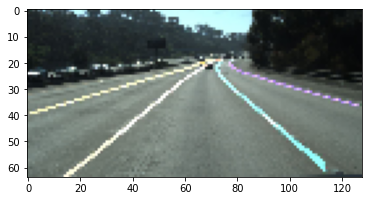

In [ ]:
plt.imshow(image)

In [ ]:
R_np = R.numpy()

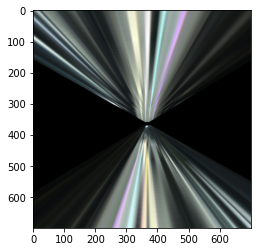

In [ ]:
plt.imshow(cv2.warpPerspective(image, R_np, dsize=(700, 700)))

As you can see it looks like a bird's eye view projection where lines are becoming parallel.

In [ ]:
class HNetLoss(_Loss):
    """
    combines H-net transformation for the matrix and Hnet loss
    """

    def __init__(self, gt_pts, transformation_coefficient, name, usegpu=True):

        super(HNetLoss, self).__init__()

        self.gt_pts = gt_pts

        self.transformation_coefficient = transformation_coefficient
        self.name = name
        self.usegpu = usegpu



    def _hnet(self):
        """
        :return:
        """
        self.transformation_coefficient = torch.cat((self.transformation_coefficient, torch.tensor([1.0])),
                                                    dim=0)
        H_indices = torch.tensor([0, 1, 2, 4, 5, 7, 8])
        H_shape = 9
        H = torch.zeros(H_shape)
        H.scatter_(dim=0, index=H_indices, src=self.transformation_coefficient)
        H = H.view((3, 3))

        pts_projects = torch.matmul(H, self.gt_pts.t())

        Y = pts_projects[1, :]
        X = pts_projects[0, :]
        Y_One = torch.ones(Y.size())
        Y_stack = torch.stack((torch.pow(Y, 3), torch.pow(Y, 2), Y, Y_One), dim=1).squeeze()
        w = torch.matmul(torch.matmul(torch.inverse(torch.matmul(Y_stack.t(), Y_stack)),
                                      Y_stack.t()),
                         X.view(-1, 1))

        x_preds = torch.matmul(Y_stack, w)
        preds = torch.stack((x_preds.squeeze(), Y, Y_One), dim=1).t()
        return (H, preds)

    def _hnet_transformation(self):
        """
        """
        H, preds = self._hnet()
        x_transformation_back = torch.matmul(torch.inverse(H), preds)

        return x_transformation_back

    def _hnet_loss(self):
        """
        """
        H, preds = self._hnet()
        x_transformation_back = torch.matmul(torch.inverse(H), preds)
        loss = torch.mean(torch.pow(self.gt_pts.t()[0, :] - x_transformation_back[0, :], 2))

        return loss

    def forward(self, input, target, n_clusters):
        return self._hnet_loss(input, target)

Finally, we need to implement the loss to fit the network. This is the most difficult part of the project. Homography loss should do the following:

1. Project ground truth trajectory to the new plane according to the homography to obtain $(x', y')$.
2. Perform polynomial fitting $x' = f(y')$. Your code should work correctly with 2-nd and 3-rd order polynomials. Polynomial fitting should be done with the closed-form solution: $w = (Y^TY)^{-1}Y^Tx$ to be able to pass a gradient through.
3. Compute back projection with the inverse homography.
4. Compute loss between back projected $\hat{x}$ and ground truth $x$.

The full description can be found in the [LaneNet paper](https://arxiv.org/pdf/1802.05591.pdf).

**IMPORTANT NOTES**

* To fit the polynomial you need to compute the inverse matrix. Computation of the inverse is computation unstable operation. With the help of the SVD you can compute pseudo-inverse matrix: $(X^TX)^{-1}X^T$. In torch this function is called `torch.pinverse`.
* After projection use of the raw $y'$ can be impractical. The features for the polynomial fitting could have a high correlation and therefore solution can be unstable. At first, you need to map $y'$ to some fixed size segment and only then perform a fit.
* After projection some points can occur on the other side of image (bottom part of the projection in the example above). You may want to exclude them, because otherwise polynomial is not going to have much sense and gradients can have a dramatically large values. Positive $w$ in homogeneous coordinates indicates that point is on the wrong side.
* If use the homography provided above, your ground truth should have the same scale, as an image
* Every division in your network is a potential place to obtain `nan` in gradients. Use the following trick to obtain less divisions:
after computing the projection, remember the $w$. Then, before the back projection, multiply your vector by $w$. After back projection you will see that $w$ is equal to 1. So you don't need to devide your vector by $w$.
* You correction to the initial homography could be very big and can completely spoil the homography. So you may need to scale the output of the last layer in the HNet to obtain a smaller corrections.


In [ ]:
class HomographyLoss(torch.nn.modules.loss._Loss):
    def __init__(self, size_average=True):
        super(HomographyLoss, self).__init__(size_average=size_average)

    def forward(self, input, target):
        # TODO
        pass

Finally, train the homography net with the 2-nd order polynomial fitting (you can 3-rd order but we found out that it is much easier to train h-net with the 2-nd order polynomials).

We found out that SGD fits much better for this architectures. Adam (and momentums inside) can ruin the weights because of the discontinuities in the target function surface.

Demonstrate the difference in homography loss between h-net and provided fixed homography on the validation samples.

In [ ]:
# Train the H-Net

# Complete Pipeline

Now you need to implement a class that takes image and a set of $y$ coordinates as an input and returns the $x$ coordinate for each lane in this image.

It should contain the following steps:

1. Apply segmentation network to the image
2. Run DBSCAN over the embeddings for those pixels that are lanes.
3. Apply h-net to the image
4. Project pixel coordinates with the predicted homograpgy
5. Fit the 3-rd order polynomial
6. Predict the lane position for each provided $y$ (you should project this first).
7. Compute back projection and return the positions of $x$ for each lane.

Note: if you weren't able to train the H-Net, you can use the fixed homography here.

In [ ]:
import numpy as np
import glog as log
from sklearn.cluster import MeanShift
from sklearn.cluster import DBSCAN
import time
import warnings
import cv2
try:
    from cv2 import cv2
except ImportError:
    pass


class LaneDetector(object):


    def __init__(self):
        """
        """
        self._color_map = [np.array([255, 0, 0]),
                           np.array([0, 255, 0]),
                           np.array([0, 0, 255]),
                           np.array([125, 125, 0]),
                           np.array([0, 125, 125]),
                           np.array([125, 0, 125]),
                           np.array([50, 100, 50]),
                           np.array([100, 50, 100])]
        pass

    def _cluster(prediction, bandwidth):
        """
        predicting clusters
        """
        ms = MeanShift(bandwidth, bin_seeding=True)
        log.info('Mean shift is ')
        tic = time.time()
        try:
            ms.fit(prediction)
        except ValueError as err:
            log.error(err)
            return 0, [], []
        log.info('Mean Shift is: {:.5f}s'.format(time.time() - tic))
        labels = ms.labels_
        cluster_centers = ms.cluster_centers_

        num_clusters = cluster_centers.shape[0]

        log.info('number of clusters is: {:d}'.format(num_clusters))

        return num_clusters, labels, cluster_centers

    @staticmethod
    def _dbscan(prediction):
        """
        dbscan clustering
        """
        db = DBSCAN(eps=0.7, min_samples=200).fit(prediction)
        db_labels = db.labels_
        unique_labels = np.unique(db_labels)
        unique_labels = [tmp for tmp in unique_labels if tmp != -1]
        log.info('聚类簇个数为: {:d}'.format(len(unique_labels)))

        num_clusters = len(unique_labels)
        cluster_centers = db.components_

        return num_clusters, db_labels, cluster_centers

    def _get_lane_area(binary_seg_ret, instance_seg_ret):

        print(binary_seg_ret.shape, instance_seg_ret.shape)
        idx = np.where(binary_seg_ret == 1)

        lane_embedding_feats = []
        lane_coordinate = []
        for i in range(len(idx[0])):
            lane_embedding_feats.append(instance_seg_ret[idx[0][i], idx[1][i]])
            lane_coordinate.append([idx[0][i], idx[1][i]])
        print(len(idx[0]))
        return np.array(lane_embedding_feats, np.float32), np.array(lane_coordinate, np.int64)

    def _thresh_coord(coord):

        pts_x = coord[:, 0]
        mean_x = np.mean(pts_x)

        idx = np.where(np.abs(pts_x - mean_x) < mean_x)

        return coord[idx[0]]

    def _lane_fit(lane_pts):
        """
        lane fitting
        """
        if not isinstance(lane_pts, np.ndarray):
            lane_pts = np.array(lane_pts, np.float32)

        x = lane_pts[:, 0]
        y = lane_pts[:, 1]
        x_fit = []
        y_fit = []
        with warnings.catch_warnings():
            warnings.filterwarnings('error')
            try:
                f1 = np.polyfit(y, x, 3)
                p1 = np.poly1d(f1)
                y_min = int(np.min(y))
                y_max = int(np.max(y))
                y_fit = []
                for i in range(y_min, y_max + 1):
                    y_fit.append(i)
                x_fit = p1(y_fit)
            except Warning as e:
                x_fit = x
                y_fit = y
            finally:
                return zip(x_fit, y_fit)

    def get_lane_mask(self, binary_seg_ret, instance_seg_ret, gt_image):
        """
        based on segmentation and instance results of modified Enet
        """
        lane_embedding_feats, lane_coordinate = self._get_lane_area(binary_seg_ret, instance_seg_ret)

        num_clusters, labels, cluster_centers = self._cluster(lane_embedding_feats, bandwidth=4.0)

        if num_clusters > 5:
            cluster_sample_nums = []
            for i in range(num_clusters):
                cluster_sample_nums.append(len(np.where(labels == i)[0]))
            sort_idx = np.argsort(-np.array(cluster_sample_nums, np.int64))
            cluster_index = np.array(range(num_clusters))[sort_idx[0:5]]
        else:
            cluster_index = range(num_clusters)

        mask_image = np.copy(gt_image)
        for index, i in enumerate(cluster_index):
            idx = np.where(labels == i)
            print(len(idx[0]))
            coord = lane_coordinate[idx]
            color = (int(self._color_map[index][0]),
                     int(self._color_map[index][1]),
                     int(self._color_map[index][2]))
            coord = np.array(coord)
            mask_image[coord[:,0], coord[:,1], :] = color

        return mask_image, lane_coordinate, cluster_index, labels


if __name__ == '__main__':
    binary_seg_image = cv2.imread('binary_ret.png', cv2.IMREAD_GRAYSCALE)
    binary_seg_image[np.where(binary_seg_image == 255)] = 1
    instance_seg_image = cv2.imread('instance_ret.png', cv2.IMREAD_UNCHANGED)
    ele_mex = np.max(instance_seg_image, axis=(0, 1))
    for i in range(3):
        if ele_mex[i] == 0:
            scale = 1
        else:
            scale = 255 / ele_mex[i]
        instance_seg_image[:, :, i] *= int(scale)
    embedding_image = np.array(instance_seg_image, np.uint8)
    cluster = LaneNetCluster()
    mask_image = cluster.get_lane_mask(instance_seg_ret=instance_seg_image, binary_seg_ret=binary_seg_image)

In [ ]:
!mv /data/training/clips/* /data/clips/

In [ ]:
!mv /data/testing/clips/* /data/clips/

mv: cannot move '/data/testing/clips/0531' to '/data/clips/0531': Directory not empty
mv: cannot move '/data/testing/clips/0601' to '/data/clips/0601': Directory not empty
